In [14]:
import pandas as pd
from scipy.signal import peak_widths, find_peaks
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [105]:
def read_file(file):
    
    pd_dataframe = pd.read_csv(file, header=[1,2])
    filename = file.split('/')[-1].split('_')
    filename = filename[0] + ' ' + filename[1] + ' ' + filename[2]
    return pd_dataframe, filename

def fix_column_names(pd_dataframe):
    
    header_1 = pd_dataframe.columns.get_level_values(0)
    header_2 = pd_dataframe.columns.get_level_values(1)
    col_names = []

    for i in range(len(header_1)):
        col_names.append(' '.join([header_1[i], header_2[i]]))
        
    pd_dataframe.columns = col_names
    
    return pd_dataframe


def filter_predictions(pd_dataframe, bodypart, threshold):
    
    if type(bodypart) is list and len(bodypart) > 1:
        for bodypart in bodypart:
            pd_dataframe = pd_dataframe[pd_dataframe[bodypart + ' likelihood'] >= threshold]
    
    elif type(bodypart) is list and len(bodypart) == 1:
        pd_dataframe = pd_dataframe[pd_dataframe[bodypart[0] + ' likelihood'] >= threshold]
    
    elif type(bodypart) is str:
        pd_dataframe = pd_dataframe[pd_dataframe[bodypart + ' likelihood'] >= threshold]
        
    # raise error if any bodypart name not identical as in csv
        
    return pd_dataframe


def find_slips(pd_dataframe, bodypart, axis, method, **kwargs): 
        

    if method == 'deviation':
    
        t_peaks, properties = find_peaks(-pd_dataframe[f'{bodypart} {axis}'], height=-5000, prominence=(10,100000))
        n_peaks = len(t_peaks)        
        h_peaks = properties["prominences"]
        start_times = properties['left_bases']
        end_times = properties['right_bases']

    if method == 'baseline':
        
        baseline = baseline_als(pd_dataframe[f'{bodypart} {axis}'], 1, 0.01)
#         corrected = pd_dataframe[f'{bodypart} {axis}'] - baseline

        t_peaks, properties = find_peaks(-baseline, height=-5000, prominence=(10,100000))
        n_peaks = len(t_peaks)
        h_peaks = properties["prominences"]
        start_times = properties['left_bases']
        end_times = properties['right_bases']
            
    return n_peaks, list(h_peaks), list(t_peaks), list(start_times), list(end_times)


def baseline_als(y, lam, p, niter=10):

    from scipy import sparse
    from scipy.sparse.linalg import spsolve

    '''
    * based on ALS paper
    There are two parameters: 
    p for asymmetry and λ for smoothness. 
    Both have to be tuned to the data at hand. 
    We found that generally 0.001 ≤ p ≤ 0.1 is a good choice 
    (for a signal with positive peaks) 
    and 10^2 ≤ λ ≤ 10^9 , 
    but exceptions may occur. 
    In any case one should vary λ on a grid that is approximately linear for log λ
    '''
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


def plot_data(pd_dataframe, bodyparts, start, end, file_identifier, axis = 'y', threshold = 0):
    
#     if threshold > 0:
#         pd_dataframe = filter_predictions(pd_dataframe, bodyparts, threshold)
        
    plt.figure(figsize=(20,5))
    labels = []
    
    if type(axis) is list:
        
        if type(bodyparts) is list and len(bodyparts) > 1:
            for bodypart in bodyparts:
                plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodypart, axis[0])][start:end], s=1)
                plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodypart, axis[1])][start:end], s=1)
            for which_axis in axis:
                for bodypart in bodyparts:
                    labels.append('%s %s' %(bodypart, which_axis))
                
        elif type(bodyparts) is list and len(bodyparts) == 1:
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts[0], axis[0])][start:end], s=1)
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts[0], axis[1])][start:end], s=1)
            for which_axis in axis:
                labels.append('%s %s' %(bodyparts[0], which_axis))
            
        elif type(bodyparts) is str:
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts, axis[0])][start:end], s=1)
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts, axis[1])][start:end], s=1)
            for which_axis in axis:
                labels.append('%s %s' %(bodyparts, which_axis))
    
    else:
        
        if type(bodyparts) is list and len(bodyparts) > 1:
            for bodypart in bodyparts:
                plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodypart, axis)][start:end], s=1)
                labels.append('%s %s' %(bodypart, axis))
        elif type(bodyparts) is list and len(bodyparts) == 1:
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts[0], axis)][start:end], s=1)
            labels.append('%s %s' %(bodyparts[0], axis))
        elif type(bodyparts) is str:
            plt.scatter(df['bodyparts coords'][start:end], df['%s %s' %(bodyparts, axis)][start:end], s=1)
            labels.append('%s %s' %(bodyparts, axis))
            
            
    if threshold < 1:
        low_likelihood = np.array(pd_dataframe[pd_dataframe[bodyparts + ' likelihood'] < threshold]['bodyparts coords'])
        low_likelihood = low_likelihood[low_likelihood >= start]
        low_likelihood = low_likelihood[low_likelihood <= end]

        for i in low_likelihood:
    #         print(i)
            plt.axvspan(i, i+1, facecolor='0.2', alpha=0.5)
        
    plt.legend(labels)
    plt.xlabel('n frame')
    plt.ylabel('distance from 0 (pixel)')
    plt.title('%s coordinates by frame' % file_identifier)
    
def plot_slips(pd_dataframe, bodypart, slip_t):
    
    index = pd_dataframe['bodyparts coords']
    data = pd_dataframe['%s y' %bodypart]
    
    plt.figure(figsize=(20,5))
    plt.scatter(index, data, s=1)
    plt.scatter(index.iloc[slip_t], data.iloc[slip_t], s=15,color='r')
    plt.legend(['coordinate', 'peak'])
    plt.xlabel('n frame')
    plt.ylabel('distance from 0 (pixel)')
#     plt.vlines(x=index.iloc[slip_t], ymin=data.iloc[slip_t] + properties["prominences"], ymax=data.iloc[slip_t], color="r")
     
#     h_peaks = np.mean(properties["prominences"])    
#     print(h_peaks, 'pixels')   

In [154]:
filename = '/home/annette/Desktop/Irregular_347_3dpi_croppedDLC_resnet50_Ladder RungMay12shuffle1_50000.csv'
video = '/home/annette/Desktop/Irregular_347_3dpi_cropped.avi'

In [155]:
df, filename = read_file(filename)
df = fix_column_names(df)
df = filter_predictions(df, 'HR', 0)

In [156]:
bodypart = 'HR'

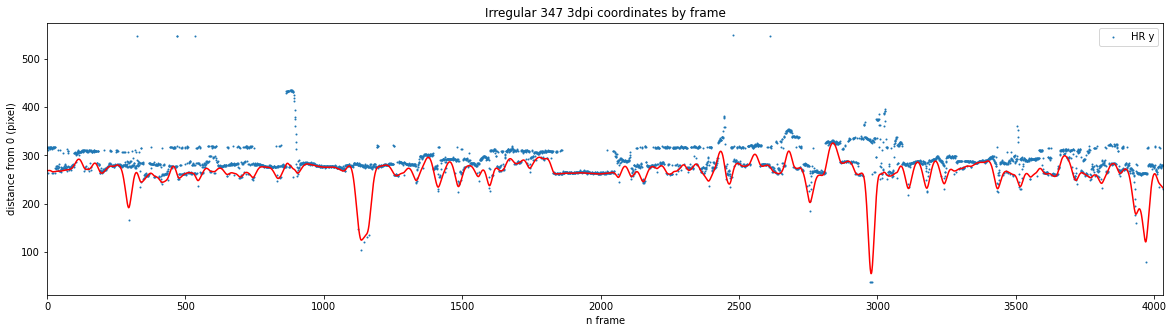

In [69]:
plot_data(df, bodypart, 0, len(df), filename, 'y', 1)
plt.xlim(0, len(df))

baseline = baseline_als(df['%s %s' %(bodypart, 'y')][0:len(df)], 10**2, 0.01)
plt.plot(df['bodyparts coords'][0:len(df)], baseline, 'r')

# plt.figure(figsize=(20,5))
# plt.scatter(df['bodyparts coords'][0:len(df)], df['%s %s' %(bodypart, 'y')][0:len(df)]-baseline, s=1)
# plt.xlim(0, len(df))
# df['%s y' %bodypart] = df['%s y' %bodypart][0:len(df)]-baseline

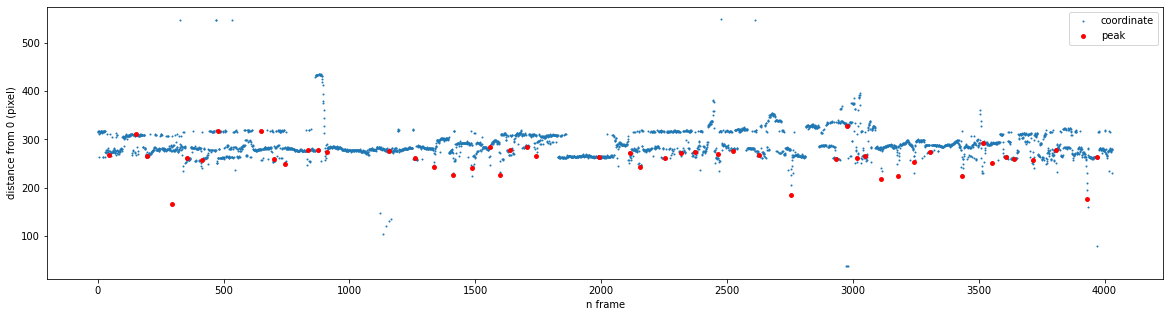

In [106]:
def find_slips(pd_dataframe, bodypart, axis, method, **kwargs): 
        

    if method == 'deviation':
    
        t_peaks, properties = find_peaks(-pd_dataframe[f'{bodypart} {axis}'], height=-5000, prominence=(10,100000))
        n_peaks = len(t_peaks)        
        h_peaks = properties["prominences"]
        start_times = properties['left_bases']
        end_times = properties['right_bases']

    if method == 'baseline':
        
        baseline = baseline_als(pd_dataframe[f'{bodypart} {axis}'], 10**2, 0.1)
#         corrected = pd_dataframe[f'{bodypart} {axis}'] - baseline

        t_peaks, properties = find_peaks(-baseline, height=-10000, prominence=(10,100000))
        n_peaks = len(t_peaks)
        h_peaks = properties["prominences"]
        start_times = properties['left_bases']
        end_times = properties['right_bases']
            
    return n_peaks, list(h_peaks), list(t_peaks), list(start_times), list(end_times)

# baseline = baseline_als(df['%s %s' %(bodypart, 'y')][0:len(df)], 10**2, 0.01)
# plt.plot(df['bodyparts coords'][0:len(df)], baseline, 'r')


n_peaks, h_peaks, t_peaks, _, _ = find_slips(df, 'HR', 'y', 'baseline')
plot_slips(df, bodypart, t_peaks)

In [83]:
n_peaks

50

In [152]:
def fit_threshold(y, threshold):
    
    result = np.full(len(y), threshold)
    for i, data in enumerate(y):
        if data < threshold:
            result[i] = y[i]
    return result

In [174]:
sublist = [1, 2]
sublist.index(np.min(sublist))

0

In [177]:
def adjust_times(y, t_prediction, window):
    
    for i, t in enumerate(t_prediction):
        start = t - window
        end = t + window
        if start < 0:
            start = 0
        if end > len(y):
            end = len(y)
        sublist = list(y[start:end])
        minimum = start + sublist.index(np.min(sublist))
        t_prediction[i] = minimum
    
    return t_prediction

26

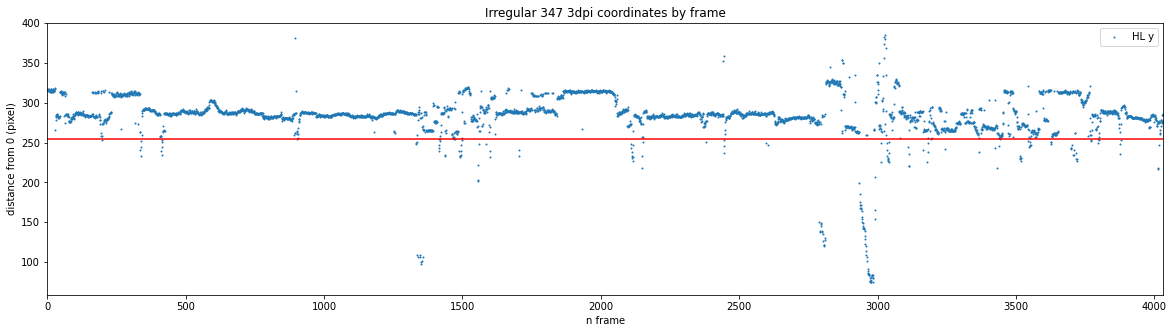

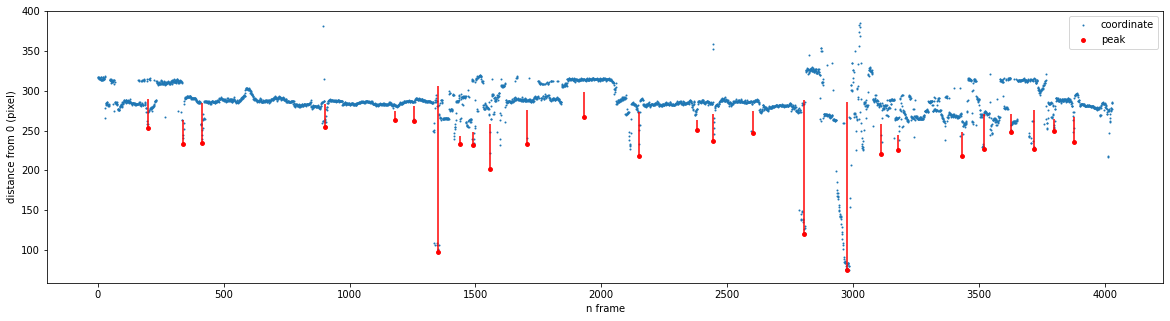

In [181]:
bodypart = 'HL'

def find_slips(pd_dataframe, bodypart, axis, method, window = 5, threshold = None, **kwargs): 
        

    if method == 'deviation':
    
        t_peaks, properties = find_peaks(-pd_dataframe[f'{bodypart} {axis}'], height=-10000, prominence=(10,100000))

    if method == 'baseline':
        
        baseline = baseline_als(pd_dataframe[f'{bodypart} {axis}'], 8**3, 0.01)
#         corrected = pd_dataframe[f'{bodypart} {axis}'] - baseline

        t_peaks, properties = find_peaks(-baseline, prominence=(10,1000))
        t_peaks = adjust_times(pd_dataframe[f'{bodypart} {axis}'], t_peaks, window)

    if method == 'threshold':
        
        if threshold is None:  
            
            threshold = np.mean(pd_dataframe[f'{bodypart} {axis}']) - np.std(pd_dataframe[f'{bodypart} {axis}'])
        
        adjusted = fit_threshold(pd_dataframe[f'{bodypart} {axis}'], threshold)
        
        t_peaks, properties = find_peaks(-adjusted, prominence=(10,1000))
    n_peaks = len(t_peaks)
    h_peaks = properties["prominences"]
    start_times = properties['left_bases']
    end_times = properties['right_bases']
        
    return n_peaks, list(h_peaks), list(t_peaks), list(start_times), list(end_times)

plot_data(df, bodypart, 0, len(df), filename, 'y', 1)
plt.xlim(0, len(df))
plt.hlines(y=np.mean(df[f'{bodypart} y']) - np.std(df[f'{bodypart} y']), xmin = 0, xmax = len(df), colors='r')
# baseline = baseline_als(df['%s %s' %(bodypart, 'y')][0:len(df)], 8**3, 0.01)
# plt.plot(df['bodyparts coords'][0:len(df)], baseline, 'r')


n_peaks, h_peaks, t_peaks, _, _ = find_slips(df, bodypart, 'y', 'baseline', window = 20)
plot_slips(df, bodypart, t_peaks)
plt.vlines(x=df['bodyparts coords'][t_peaks], ymin=df['%s %s' %(bodypart, 'y')].iloc[t_peaks] + h_peaks, ymax=df['%s %s' %(bodypart, 'y')].iloc[t_peaks], color="r")
n_peaks

In [103]:
h_peaks

[27.838540797758526,
 25.41897688254926,
 20.90150349201309,
 71.76530926605378,
 21.75463616941113,
 34.293216631234486,
 27.3487561052886,
 10.18749392691484,
 13.847068250195434,
 29.191004450756395,
 19.93347235368867,
 19.365141957533524,
 29.57078689086177,
 19.02260037299095,
 17.148535324969032,
 152.90201597796693,
 23.14724882520437,
 29.244417091207367,
 45.158876896539425,
 54.73662652222657,
 17.20900162408708,
 47.935180835729284,
 22.237027076056847,
 22.23031192135892,
 24.31336948112829,
 26.6623475267628,
 11.028476804330126,
 21.57719880128826,
 60.32155188441837,
 24.073458049851695,
 13.931572315363326,
 21.592440766159314,
 32.961224944002765,
 86.5626611971567,
 13.123883584252326,
 54.237985242856666,
 118.82765133775194,
 64.31067707145445,
 217.2441862531595,
 43.39824693195999,
 45.36631615313985,
 52.90057891184523,
 42.2037589931424,
 39.69374239416385,
 21.122632387913484,
 65.000058130143,
 46.122808008206476,
 23.14342438816726,
 20.385677933279624,
 44.